In [1]:
import math
import h5py
import pickle
import random
import pysam
import numpy as np
import pandas as pd
import os
import pickle as pkl
import viz_sequence
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import scipy.ndimage

scores_dir = '/oak/stanford/groups/akundaje/projects/chrombpnet/deepshap_from_merged_bed'
peak_dir = '/oak/stanford/groups/akundaje/projects/chrombpnet/bigwigs_unplugged_bias/joint_overlap'
outdir = '/oak/stanford/groups/akundaje/projects/chrombpnet/modisco_inputs'
hg38_fasta = '/oak/stanford/groups/akundaje/refs/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta'

ref_genome = pysam.FastaFile(hg38_fasta)

score_types = ['count', 'profile']
tasks = os.listdir(outdir)
chroms = ['chr' + str(i) for i in range(1,23)]

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1):
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        elif (char=="I" or char=="i"):
            continue #leave that pos as all 0's
        else:
            continue
            #raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


flank = 1057
celltype = "GM12878"
subsample=False
per_split = 50000

peak_file = peak_dir + '/' + celltype + '.' "overlap.ATAC.DNASE.merged.bed"
peaks = pd.read_csv(peak_file, header=None, sep='\t')
peaks = peaks.loc[peaks[0].apply(lambda x: x in chroms)]
num_peaks = len(peaks)

if subsample:
    num_splits = num_peaks // per_split
    rand_indices = [x for x in range(num_peaks)]
    random.shuffle(rand_indices)
    i=0
    split_indices = rand_indices[(i * per_split):((i+1)*per_split)]
    split_df = peaks.iloc[split_indices].copy()
else:
    split_df = peaks
                  
output_reg = {}
print(tasks)
tasks = ["GM12878_dnase", "GM12878_atac"]
for task in tasks:
    print(task)
    celltype = task.split('_')[0]
    assay = task.split('_')[1]
                  
    for i in range(1):
        print('split' + str(i))
        for score_type in score_types:
            print(score_type)
            hyp_impscores = {}
            hseqs = {}
            onehot = []
            for chrom in chroms:
                print(chrom)
                chrom_split_df = split_df.loc[split_df[0] == chrom].copy()
                if len(chrom_split_df) > 0:
                    scores_path = scores_dir + '/' + task + '/' + celltype + '.' + assay.upper() \
                                  + '.Overlap.Fold0.hyp.' + score_type + '.deepshap.' + chrom + '.pkl'
                    scores_file = open(scores_path, 'rb')
                    scores = pickle.load(scores_file)

                    for index,row in chrom_split_df.iterrows():
                        # centering at the midpoint of overlap bed region
                        center = (row[1] + row[2]) // 2
                        start = center - flank
                        end = center + flank
                        
                        seq = ref_genome.fetch(chrom, start, end)
                        seq = seq.upper()
                        
                        hseqs[chrom+":"+str(start)+":"+str(end)] = seq
                        peak_onehot = one_hot_encode_along_channel_axis(seq)
                        hyp_impscores[chrom+":"+str(start)+":"+str(end)] = np.sum(scores[start:end]*peak_onehot,axis=1) 
                    scores_file.close()
            output_reg[assay+"_"+score_type]  = hyp_impscores
            output_reg[assay+"_"+score_type+"_seq"]  = hseqs

['H1HESC_dnase', 'H1HESC_atac', 'HEPG2_atac', 'GM12878_atac', 'K562_dnase', 'IMR90_atac', 'HEPG2_dnase', 'GM12878_dnase', 'IMR90_dnase']
GM12878_dnase
split0
count
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
profile
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
GM12878_atac
split0
count
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
profile
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [19]:
#print(output_reg.keys())
#output_reg = output


##output_reg is a dictionary with "dnase_count"

In [3]:
print(len(list(output_reg["dnase_count"])))

152370


In [4]:
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import scipy.ndimage

def get_pairwise_metrics(atac_data, dnase_data, input_keys=None):
  
    pearsonr_corr=[]
    pearsonr_random=[]
    
    spearmanr_corr=[]
    spearmanr_random=[]
    jsd_corr=[]
    jsd_random=[]
    jsd_random1=[]   
    
    if input_keys==None:
        input_keys=atac_data.keys()
        
    for region in input_keys:
        atac_sig = atac_data[region]
        dnase_sig = dnase_data[region]
        
        atac_sig = np.abs(atac_sig)+1e-10
        dnase_sig = np.abs(dnase_sig)+1e-10
            
        atac_sig = atac_sig / np.sum(atac_sig)
        dnase_sig = dnase_sig / np.sum(dnase_sig)
        
        atac_sig = scipy.ndimage.gaussian_filter1d(atac_sig, 7, truncate=(80 / 14))
        dnase_sig = scipy.ndimage.gaussian_filter1d(dnase_sig, 7, truncate=(80 / 14))

        rnd_atac_sig = np.random.permutation(atac_sig)
        rnd_region = random.sample(input_keys,1)
        
        while rnd_region == region:
            rnd_region = random.sample(input_keys,1)
        rnd_region=rnd_region[0]
        rnd_reg_atac_sig = atac_data[rnd_region]
        rnd_reg_atac_sig = np.abs(rnd_reg_atac_sig)+1e-10
        rnd_reg_atac_sig = rnd_reg_atac_sig / np.sum(rnd_reg_atac_sig)
        rnd_reg_atac_sig = scipy.ndimage.gaussian_filter1d(rnd_reg_atac_sig, 7, truncate=(80 / 14))


        pearsonr_corr.append(pearsonr(atac_sig, dnase_sig)[0])
        pearsonr_random.append(pearsonr(rnd_reg_atac_sig, dnase_sig)[0])

        spearmanr_corr.append(spearmanr(atac_sig, dnase_sig)[0])
        spearmanr_random.append(spearmanr(rnd_reg_atac_sig, dnase_sig)[0])
        
        jsd_corr.append(jensenshannon(atac_sig, dnase_sig, 2.0))
        jsd_random.append(jensenshannon(rnd_atac_sig, dnase_sig, 2.0))
        jsd_random1.append(jensenshannon(rnd_reg_atac_sig, dnase_sig, 2.0))
    
    print(sum(np.isnan(pearsonr_corr)))
    print(sum(np.isnan(pearsonr_random)))
    print(sum(np.isnan(spearmanr_corr)))
    print(sum(np.isnan(spearmanr_random)))
    print(sum(np.isnan(jsd_corr)))
    print(sum(np.isnan(jsd_random)))
    print(sum(np.isnan(jsd_random1)))
        
    print("mean pearsonr",np.mean(pearsonr_corr), np.std(pearsonr_corr))
    print("random mean pearsonr",np.mean(pearsonr_random), np.std(pearsonr_random))

    print("mean spearmanr",np.mean(spearmanr_corr), np.std(spearmanr_corr))
    print("random mean spearmanr",np.mean(spearmanr_random), np.std(spearmanr_random))

    print("mean jsd",np.mean(jsd_corr), np.std(jsd_corr))
    print("random (perturb) mean jsd",np.mean(jsd_random), np.std(jsd_random))
    print("random (region) mean jsd",np.mean(jsd_random1), np.std(jsd_random1))

    return pearsonr_corr, pearsonr_random, spearmanr_corr, spearmanr_random, jsd_corr, jsd_random, input_keys, jsd_random1
    
input_keys=output_reg["dnase_count"].keys()

In [5]:
count_shap_pearsonr_corr, count_shap_pearsonr_random, count_shap_spearmanr_corr, count_shap_spearmanr_random, count_shap_jsd_corr, count_shap_jsd_random, count_shap_key_list, count_shap_jsd_random1 = get_pairwise_metrics(output_reg["atac_count"], output_reg["dnase_count"],  input_keys=input_keys)

0
0
0
0
0
0
0
mean pearsonr 0.7683773500123556 0.14763832914452688
random mean pearsonr 0.21636761333091267 0.16237786126805015
mean spearmanr 0.8700958450381479 0.05271687932722387
random mean spearmanr 0.4858513305534306 0.2279554212480622
mean jsd 0.22487394252890092 0.052796736422581286
random (perturb) mean jsd 0.5606228086142268 0.06574652070601308
random (region) mean jsd 0.5065572048878867 0.07707654027331103


In [6]:
prof_shap_pearsonr_corr, prof_shap_pearsonr_random, prof_shap_spearmanr_corr, prof_shap_spearmanr_random, prof_shap_jsd_corr, prof_shap_jsd_random, prof_shap_key_list, prof_shap_jsd_random1 = get_pairwise_metrics(output_reg["atac_profile"], output_reg["dnase_profile"],  input_keys=input_keys)


0
0
0
0
0
0
0
mean pearsonr 0.8029854019670001 0.1489992137260737
random mean pearsonr 0.2769206616301272 0.1936246942061607
mean spearmanr 0.9243821487306202 0.03456118708192093
random mean spearmanr 0.6336282996528718 0.3018409450475376
mean jsd 0.22399904425773787 0.06064212642952825
random (perturb) mean jsd 0.6748960153467283 0.03625369421178327
random (region) mean jsd 0.5240185873261584 0.10880814982873267


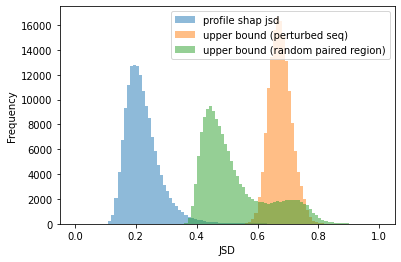

In [64]:
#print(count_shap_jsd_corr)
plt.figure()
plt.hist(prof_shap_jsd_corr, bins=100, range=(0,1), alpha=0.5, label="profile shap jsd")
plt.hist(prof_shap_jsd_random, bins=100, range=(0,1), alpha=0.5, label="upper bound (perturbed seq)")
plt.hist(prof_shap_jsd_random1, bins=100, range=(0,1), alpha=0.5, label="upper bound (random paired region)")
plt.legend()
plt.xlabel("JSD")
plt.ylabel("Frequency")
plt.show()

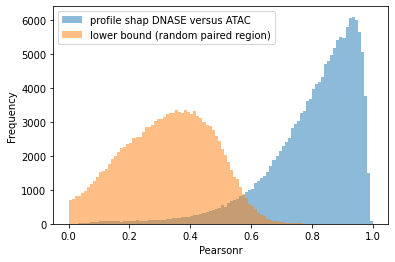

In [73]:
plt.figure()
plt.hist(prof_shap_pearsonr_corr, bins=100, range=(0,1), alpha=0.5, label="profile shap DNASE versus ATAC")
plt.hist(prof_shap_pearsonr_random, bins=100, range=(0,1), alpha=0.5, label="lower bound (random paired region)")
plt.legend()
plt.xlabel("Pearsonr")
plt.ylabel("Frequency")
plt.show()

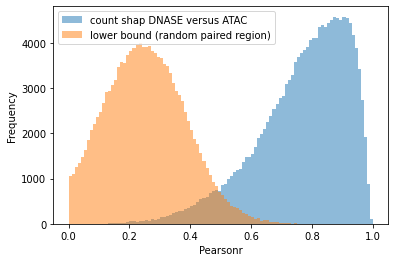

In [72]:
plt.figure()
plt.hist(count_shap_pearsonr_corr, bins=100, range=(0,1), alpha=0.5, label="count shap DNASE versus ATAC")
plt.hist(count_shap_pearsonr_random, bins=100, range=(0,1), alpha=0.5, label="lower bound (random paired region)")
plt.legend()
plt.xlabel("Pearsonr")
plt.ylabel("Frequency")
plt.show()

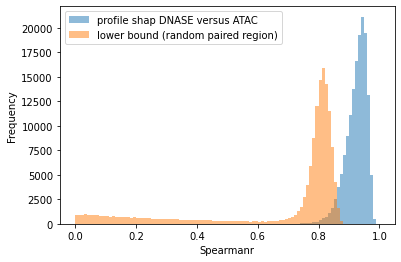

In [74]:
plt.figure()
plt.hist(prof_shap_spearmanr_corr, bins=100, range=(0,1), alpha=0.5, label="profile shap DNASE versus ATAC")
plt.hist(prof_shap_spearmanr_random, bins=100, range=(0,1), alpha=0.5, label="lower bound (random paired region)")
plt.legend()
plt.xlabel("Spearmanr")
plt.ylabel("Frequency")
plt.show()

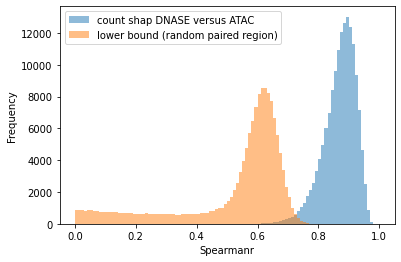

In [75]:
plt.figure()
plt.hist(count_shap_spearmanr_corr, bins=100, range=(0,1), alpha=0.5, label="count shap DNASE versus ATAC")
plt.hist(count_shap_spearmanr_random, bins=100, range=(0,1), alpha=0.5, label="lower bound (random paired region)")
plt.legend()
plt.xlabel("Spearmanr")
plt.ylabel("Frequency")
plt.show()

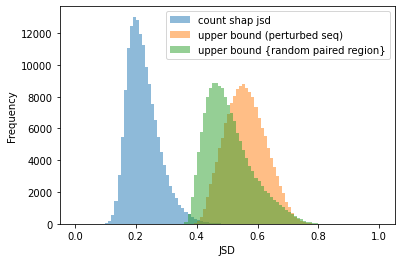

In [8]:
plt.figure()
plt.hist(count_shap_jsd_corr, bins=100, range=(0,1), alpha=0.5, label="count shap jsd")
plt.hist(count_shap_jsd_random, bins=100, range=(0,1), alpha=0.5, label="upper bound (perturbed seq)")
plt.hist(count_shap_jsd_random1, bins=100, range=(0,1), alpha=0.5, label="upper bound {random paired region}")
plt.legend()
plt.xlabel("JSD")
plt.ylabel("Frequency")
plt.show()

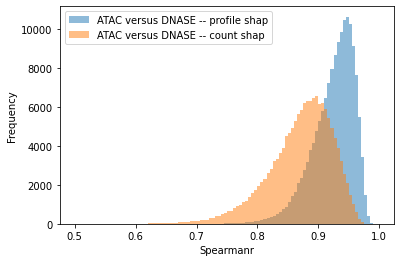

In [9]:
#print(count_shap_jsd_corr)
plt.figure()
plt.hist(prof_shap_spearmanr_corr, bins=100,range=(0.5,1), alpha=0.5, label="ATAC versus DNASE -- profile shap")
plt.hist(count_shap_spearmanr_corr, bins=100, range=(0.5,1), alpha=0.5, label="ATAC versus DNASE -- count shap")
plt.legend()
plt.xlabel("Spearmanr")
plt.ylabel("Frequency")
plt.show()

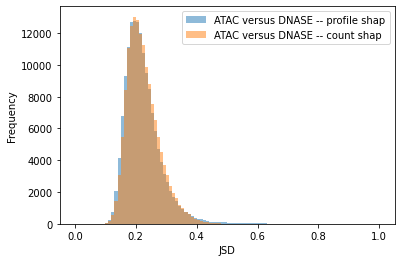

In [10]:
#print(count_shap_jsd_corr)
plt.figure()
plt.hist(prof_shap_jsd_corr, bins=100, range=(0,1), alpha=0.5, label="ATAC versus DNASE -- profile shap")
plt.hist(count_shap_jsd_corr, bins=100, range=(0,1),  alpha=0.5, label="ATAC versus DNASE -- count shap")
plt.legend()
plt.xlabel("JSD")
plt.ylabel("Frequency")
plt.show()

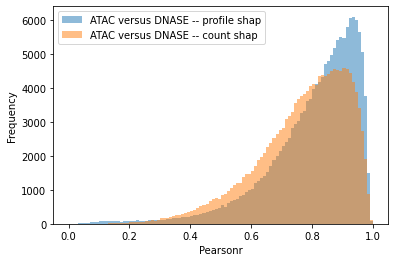

In [63]:
#print(count_shap_jsd_corr)
plt.figure()
plt.hist(prof_shap_pearsonr_corr, range=(0,1), bins=100, alpha=0.5, label="ATAC versus DNASE -- profile shap", density=False,stacked=True)
plt.hist(count_shap_pearsonr_corr, range=(0,1), bins=100, alpha=0.5, label="ATAC versus DNASE -- count shap", density=False,stacked=True)
plt.legend()
plt.xlabel("Pearsonr")
plt.ylabel("Frequency")
plt.show()


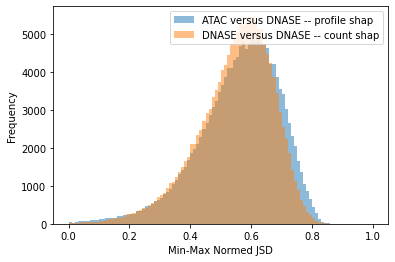

In [12]:
def min_max_norm(metric, min_val):
    normed = []
    for idx in range(len(metric)):
        val = (metric[idx]-min_val[idx])/(0-min_val[idx])
        normed.append(val)
    return normed
    
normed_prof_shap = min_max_norm(prof_shap_jsd_corr,prof_shap_jsd_random1)
normed_counr_shap = min_max_norm(count_shap_jsd_corr,count_shap_jsd_random1)
plt.figure()
plt.hist(normed_prof_shap, bins=100, range=(0,1), alpha=0.5, label="ATAC versus DNASE -- profile shap")
plt.hist(normed_counr_shap, bins=100, range=(0,1),  alpha=0.5, label="DNASE versus DNASE -- count shap")
plt.legend()
plt.xlabel("Min-Max Normed JSD")
plt.ylabel("Frequency")
plt.show()

In [13]:
print("min-max on profile shap",np.mean(normed_prof_shap),np.std(normed_prof_shap))
print("min-max on count shap",np.mean(normed_counr_shap),np.std(normed_counr_shap))

min-max on profile shap 0.558103552116231 0.13536945197244185
min-max on count shap 0.5465539359548953 0.12434141247142855


In [14]:
from scipy.interpolate import interpn
from matplotlib.colors import Normalize 
from matplotlib import cm


def density_scatter(x, y, xlab, ylab, ax = None, sort = True, bins = 20,xlim=(4,12),ylim=(4,12)):
    """
    Scatter plot colored by 2d histogram
    """
    bad_indices=np.where(np.isnan(x))+np.where(np.isnan(y))
    x=x[~np.isin(np.arange(x.size),bad_indices)]
    y=y[~np.isin(np.arange(y.size),bad_indices)]

    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    #plt.xlim(xlim)
    #plt.ylim(ylim)
    return ax

In [57]:
def make_plots(region,data):
    print("ATAC Count Shap")
    #print(data["atac_count"])
    print(region)
    print(data["dnase_count_seq"][region][0:10])
    print(data["atac_count_seq"][region][0:10])
    print(data["dnase_profile_seq"][region][0:10])
    print(data["atac_profile_seq"][region][0:10])

    act_scores = data["atac_count"][region]
    act_scores=np.tile(np.reshape(act_scores,(2114,1)),(1,4))*one_hot_encode_along_channel_axis(data["atac_count_seq"][region])
    input_length_sig = act_scores.shape[0]
    viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - flank:(input_length_sig // 2) + flank], subticks_frequency=100)
    print("ATAC Profile Shap")
    act_scores = data["atac_profile"][region]
    act_scores=np.tile(np.reshape(act_scores,(2114,1)),(1,4))*one_hot_encode_along_channel_axis(data["atac_profile_seq"][region])
    input_length_sig = act_scores.shape[0]
    viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - flank:(input_length_sig // 2) + flank], subticks_frequency=100)
    
    
    print("DNASE Count Shap")
    act_scores = data["dnase_count"][region]
    act_scores=np.tile(np.reshape(act_scores,(2114,1)),(1,4))*one_hot_encode_along_channel_axis(data["dnase_count_seq"][region])
    input_length_sig = act_scores.shape[0]
    viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - flank:(input_length_sig // 2) + flank], subticks_frequency=100)

    print("DNASE Profile Shap")
    act_scores = data["dnase_profile"][region]
    act_scores=np.tile(np.reshape(act_scores,(2114,1)),(1,4))*one_hot_encode_along_channel_axis(data["dnase_profile_seq"][region])
    input_length_sig = act_scores.shape[0]
    viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - flank:(input_length_sig // 2) + flank], subticks_frequency=100)

29559
chr1:629267:631381
normed JSD of profile shap 0.7328047936737588
normed JSD of count shap 0.7594077088544805
ATAC Count Shap
chr1:629267:631381


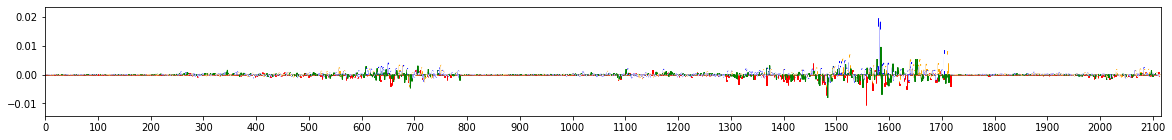

ATAC Profile Shap


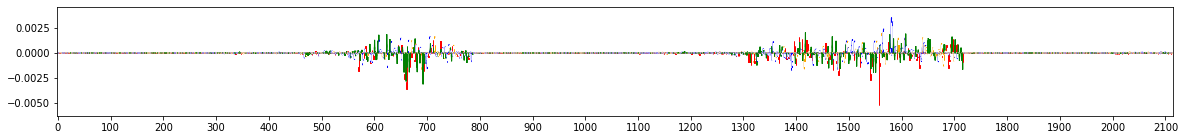

DNASE Count Shap


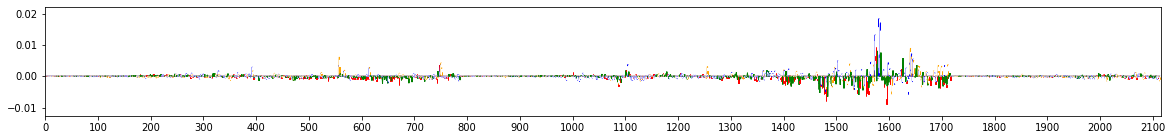

DNASE Profile Shap


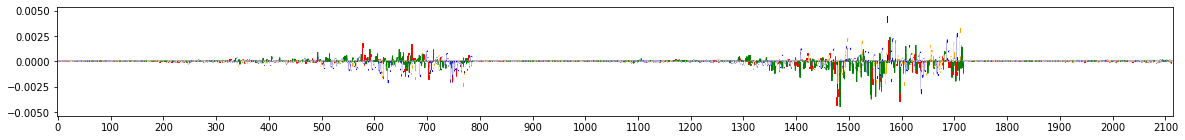

In [16]:
regions = np.logical_and(np.array(normed_counr_shap)>=0.6,np.array(normed_prof_shap)>=0.6)
intersections=np.array(list(input_keys))[regions]
print(len(intersections))

idxc=0
print(intersections[idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots(intersections[idxc], output_reg)


27279
chr1:597872:599986
normed JSD of profile shap 0.5231983187613624
normed JSD of count shap 0.6348845738168415
ATAC Count Shap
chr1:597872:599986


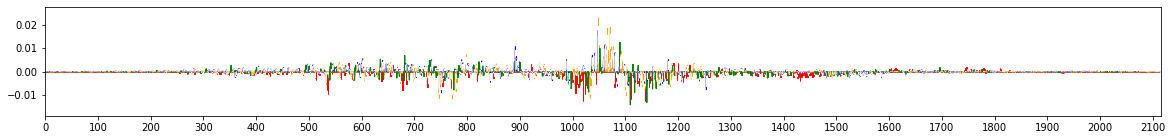

ATAC Profile Shap


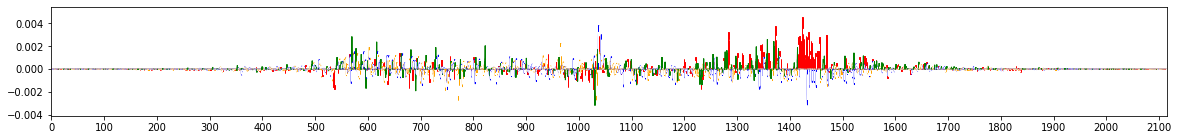

DNASE Count Shap


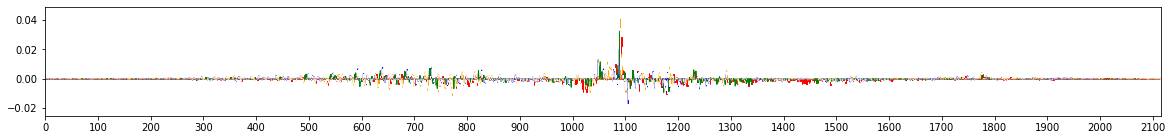

DNASE Profile Shap


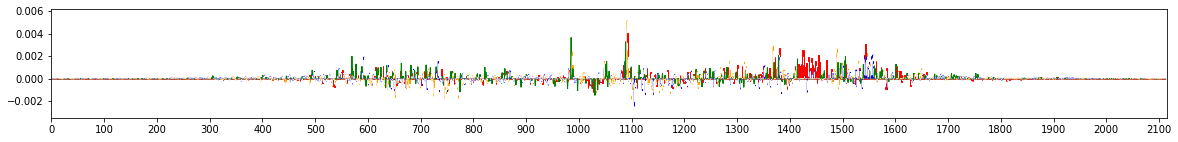

In [17]:
regions = np.logical_and(np.array(normed_counr_shap)>=0.6,np.array(normed_prof_shap)<=0.6)
intersections=np.array(list(input_keys))[regions]
print(len(intersections))

idxc=0
print(intersections[idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots(intersections[idxc], output_reg)

896
chr1:1582456:1584570
normed JSD of profile shap 0.24447341055668353
normed JSD of count shap 0.27167996435750463
ATAC Count Shap
chr1:1582456:1584570


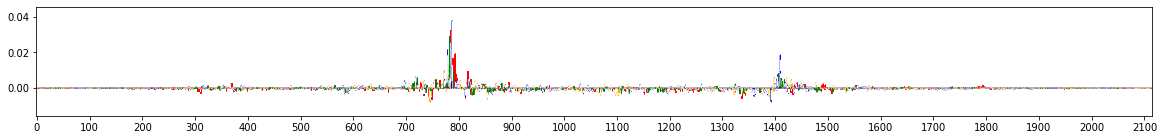

ATAC Profile Shap


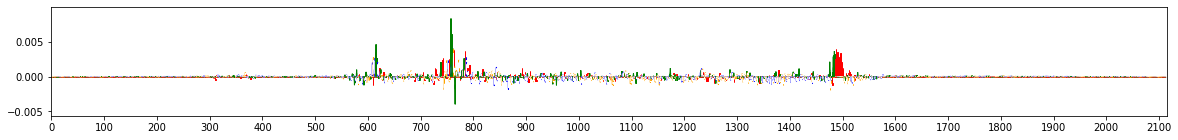

DNASE Count Shap


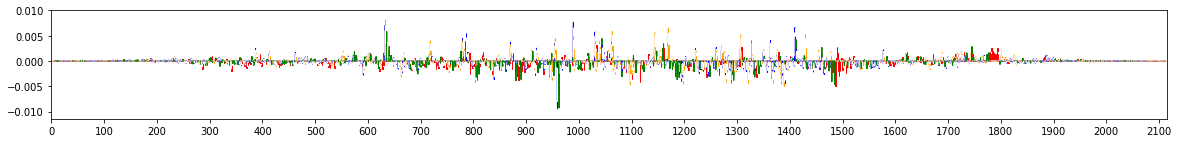

DNASE Profile Shap


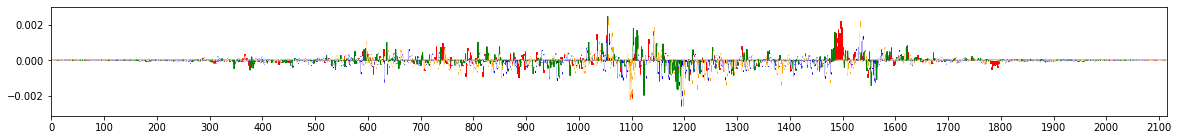

In [18]:
regions = np.logical_and(np.array(normed_counr_shap)<=0.3,np.array(normed_prof_shap)<=0.3)
intersections=np.array(list(input_keys))[regions]
print(len(intersections))

idxc=0
print(intersections[idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots(intersections[idxc], output_reg)

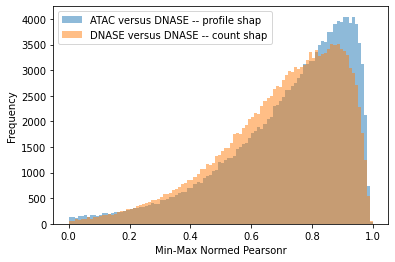

In [79]:
def min_max_norm_corr(metric, min_val):
    normed = []
    for idx in range(len(metric)):
        val = (metric[idx]-min_val[idx])/(1-min_val[idx])
        normed.append(val)
    return normed
    
normed_prof_shap1 = min_max_norm_corr(prof_shap_pearsonr_corr,prof_shap_pearsonr_random)
normed_counr_shap1 = min_max_norm_corr(count_shap_pearsonr_corr,count_shap_pearsonr_random)
plt.figure()
plt.hist(normed_prof_shap1, bins=100, range=(0,1), alpha=0.5, label="ATAC versus DNASE -- profile shap")
plt.hist(normed_counr_shap1, bins=100, range=(0,1),  alpha=0.5, label="DNASE versus DNASE -- count shap")
plt.legend()
plt.xlabel("Min-Max Normed Pearsonr")
plt.ylabel("Frequency")
plt.show()


In [82]:
print("min-max on profile shap",np.mean(normed_prof_shap1),np.std(normed_prof_shap1))
print("min-max on count shap",np.mean(normed_counr_shap1),np.std(normed_counr_shap1))

min-max on profile shap 0.7100757693636901 0.2265295362907527
min-max on count shap 0.6919519160429866 0.20547067390025775


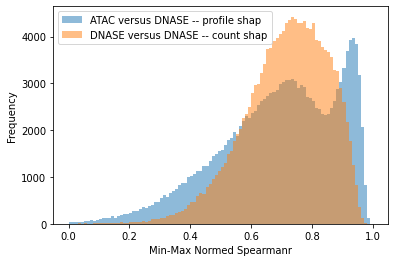

In [84]:
def min_max_norm_corr(metric, min_val):
    normed = []
    for idx in range(len(metric)):
        val = (metric[idx]-min_val[idx])/(1-min_val[idx])
        normed.append(val)
    return normed
    
normed_prof_shap2 = min_max_norm_corr(prof_shap_spearmanr_corr,prof_shap_spearmanr_random)
normed_counr_shap2 = min_max_norm_corr(count_shap_spearmanr_corr,count_shap_spearmanr_random)
plt.figure()
plt.hist(normed_prof_shap2, bins=100, range=(0,1), alpha=0.5, label="ATAC versus DNASE -- profile shap")
plt.hist(normed_counr_shap2, bins=100, range=(0,1),  alpha=0.5, label="DNASE versus DNASE -- count shap")
plt.legend()
plt.xlabel("Min-Max Normed Spearmanr")
plt.ylabel("Frequency")
plt.show()


In [85]:
print("min-max on profile shap",np.mean(normed_prof_shap2),np.std(normed_prof_shap2))
print("min-max on count shap",np.mean(normed_counr_shap2),np.std(normed_counr_shap2))

min-max on profile shap 0.6893452074657936 0.19527288809912802
min-max on count shap 0.7141594961920291 0.13630167493917797


In [86]:
out_dir="/oak/stanford/groups/akundaje/projects/chrombpnet/anusri_files/atac_dnase_scores"
import pandas as pd
header1=["region_id", "NormedJSD", "NormedPearsonr", "NormedSpearmanr", "Pearsonr", "Pearsonr_random", "Spearmanr", "Spearmanr_random", "JSD", "JSD_random", "JSD_perturb"]
datadf = pd.DataFrame(np.array([np.array(list(input_keys)), normed_prof_shap, normed_prof_shap1, normed_prof_shap2, prof_shap_pearsonr_corr, prof_shap_pearsonr_random, prof_shap_spearmanr_corr, prof_shap_spearmanr_random, prof_shap_jsd_corr, prof_shap_jsd_random1, prof_shap_jsd_random]).transpose(),
                   columns=header1)
datadf.to_csv(out_dir+"/"+celltype+".atac.dnase.profile.scores.new.csv",index=False)

In [87]:
header1=["region_id", "NormedJSD",  "NormedPearsonr", "NormedSpearmanr", "Pearsonr", "Pearsonr_random", "Spearmanr", "Spearmanr_random", "JSD", "JSD_random", "JSD_perturb"]
datadf = pd.DataFrame(np.array([np.array(list(input_keys)), normed_counr_shap, normed_counr_shap1, normed_counr_shap2, count_shap_pearsonr_corr, count_shap_pearsonr_random, count_shap_spearmanr_corr, count_shap_spearmanr_random, count_shap_jsd_corr, count_shap_jsd_random1, count_shap_jsd_random]).transpose(),
                   columns=header1)
datadf.to_csv(out_dir+"/"+celltype+".atac.dnase.count.scores.new.csv",index=False)

In [53]:
#pkl.dump(output_reg, open(out_dir+"/"+celltype+".atac.dnase.pkl","wb"))

In [89]:
header=["NormedJSD", "NormedPearsonr", "NormedSpearmanr", "Pearsonr", "Pearsonr_random", "Spearmanr", "Spearmanr_random", "JSD", "JSD_random", "JSD_perturb"]
prof_metrics = [normed_prof_shap, normed_prof_shap1, normed_prof_shap2, prof_shap_pearsonr_corr, prof_shap_pearsonr_random, prof_shap_spearmanr_corr, prof_shap_spearmanr_random, prof_shap_jsd_corr, prof_shap_jsd_random1, prof_shap_jsd_random]
count_metrics = [normed_counr_shap, normed_counr_shap1, normed_counr_shap2, count_shap_pearsonr_corr, count_shap_pearsonr_random, count_shap_spearmanr_corr, count_shap_spearmanr_random, count_shap_jsd_corr, count_shap_jsd_random1, count_shap_jsd_random]

heading = ["Statistic", "Count", "Profile"]
rows=[]
for idx in range(len(header)):
    rows.append([header[idx]+"_mean", np.round(np.mean(prof_metrics[idx]),2), np.round(np.mean(count_metrics[idx]),2)])
    rows.append([header[idx]+"_std", np.round(np.std(prof_metrics[idx]),2), np.round(np.std(count_metrics[idx]),2)])

datadf = pd.DataFrame(rows, columns=heading)
datadf.to_csv(out_dir+"/"+celltype+".atac.dnase.summary.new.csv",index=False)

In [ ]:
regions = np.logical_and(np.array(normed_counr_shap)>=0.8,np.array(normed_prof_shap)>=0.8)
intersections=np.array(list(input_keys))[regions]
print(intersections)

regions = np.logical_and(np.array(normed_counr_shap)<=0.1,np.array(normed_prof_shap)<=0.1)
intersections=np.array(list(input_keys))[regions]
print(intersections)

3152
chr1:629267:631381
normed JSD of profile shap 0.7328047936737588
normed JSD of count shap 0.7594077088544805
ATAC Count Shap
chr1:629267:631381
ACTTCTGACC
ACTTCTGACC
ACTTCTGACC
ACTTCTGACC


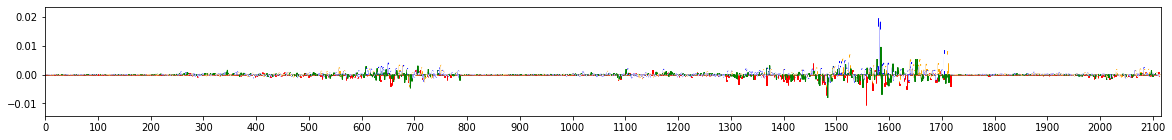

ATAC Profile Shap


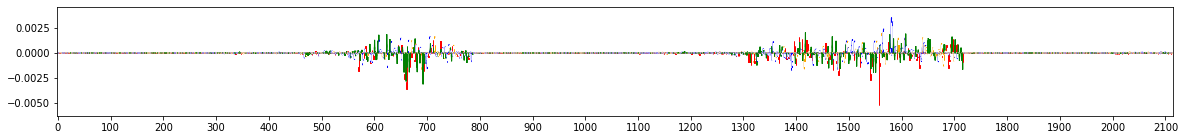

DNASE Count Shap


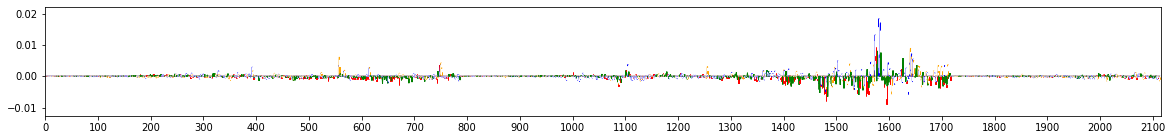

DNASE Profile Shap


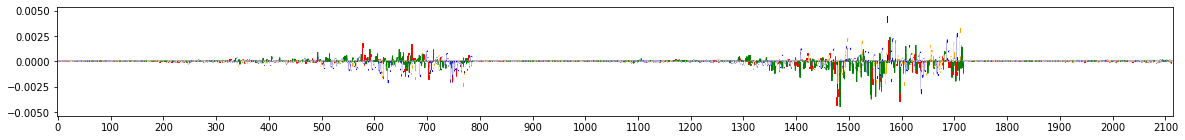

In [91]:
regions = np.logical_and(np.array(normed_counr_shap)>=0.7,np.array(normed_prof_shap)>=0.7)
intersections=np.array(list(input_keys))[regions]
print(len(intersections))

idxc=0
print(intersections[idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots(intersections[idxc], output_reg)

896
chr1:14914396:14916510
normed JSD of profile shap 0.16791960445226672
normed JSD of count shap 0.1558937352534755
ATAC Count Shap
chr1:14914396:14916510
TTGGGATGCC
TTGGGATGCC
TTGGGATGCC
TTGGGATGCC


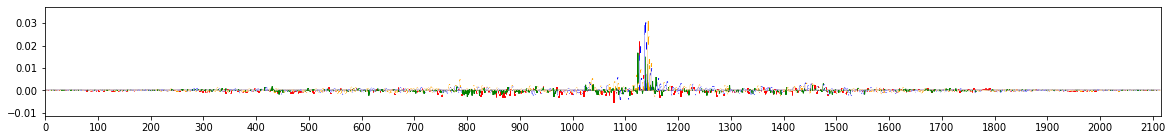

ATAC Profile Shap


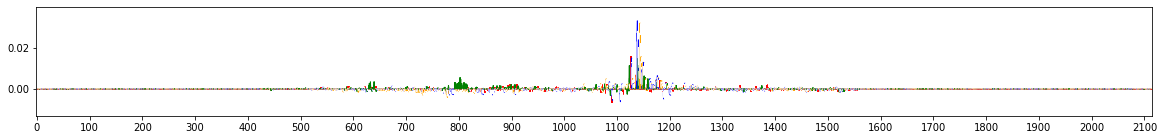

DNASE Count Shap


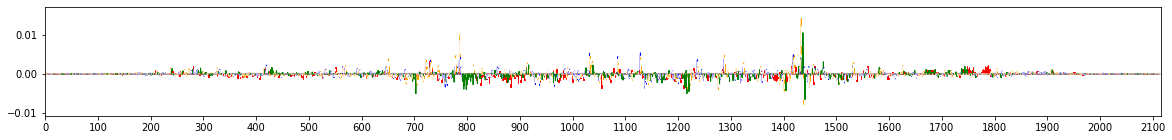

DNASE Profile Shap


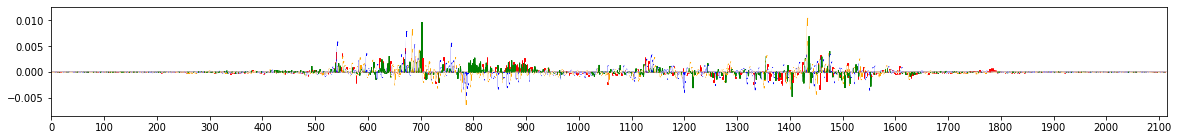

In [93]:
regions = np.logical_and(np.array(normed_counr_shap)<=0.3,np.array(normed_prof_shap)<=0.3)
intersections=np.array(list(input_keys))[regions]
print(len(intersections))

idxc=1
print(intersections[idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots(intersections[idxc], output_reg)

3152
chr1:84845612:84847726
normed JSD of profile shap 0.7424442784713426
normed JSD of count shap 0.7068703716660143
ATAC Count Shap
chr1:84845612:84847726
TTGGTCCATC
TTGGTCCATC
TTGGTCCATC
TTGGTCCATC


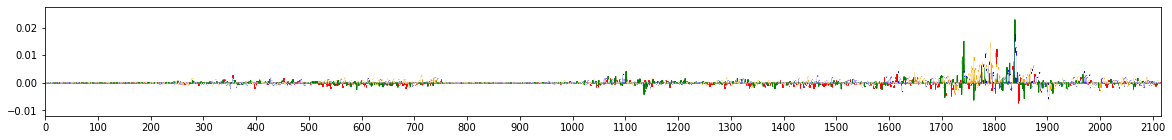

ATAC Profile Shap


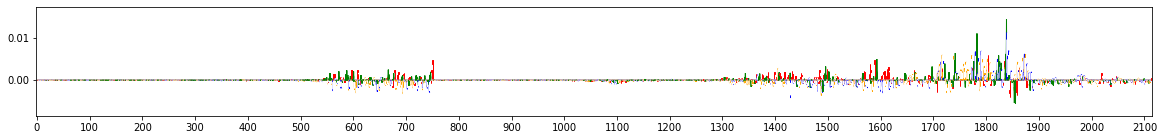

DNASE Count Shap


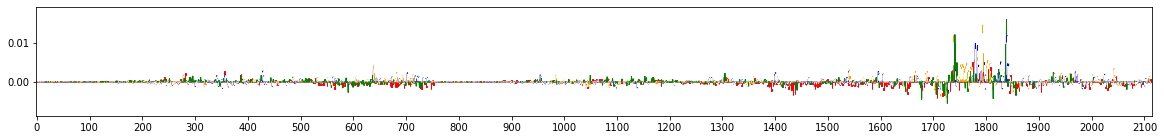

DNASE Profile Shap


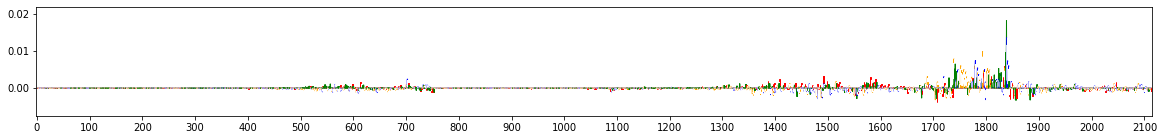

In [94]:
regions = np.logical_and(np.array(normed_counr_shap)>=0.7,np.array(normed_prof_shap)>=0.7)
intersections=np.array(list(input_keys))[regions]
print(len(intersections))

idxc=100
print(intersections[idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots(intersections[idxc], output_reg)

17
chr20:3766144:3768258
normed JSD of profile shap 0.8375672765521822
normed JSD of count shap 0.8028716702592046
ATAC Count Shap
chr20:3766144:3768258
TGGCTCAAGC
TGGCTCAAGC
TGGCTCAAGC
TGGCTCAAGC


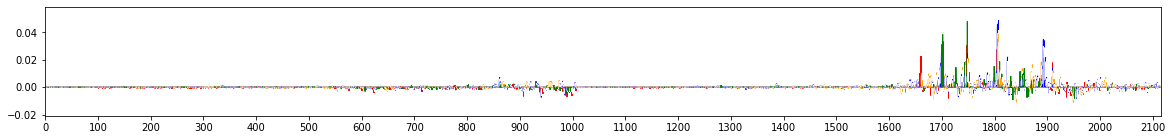

ATAC Profile Shap


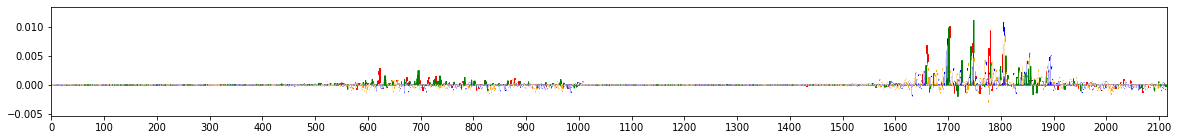

DNASE Count Shap


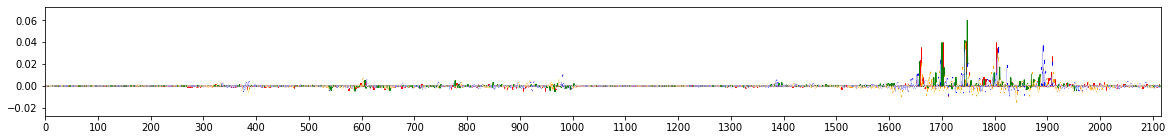

DNASE Profile Shap


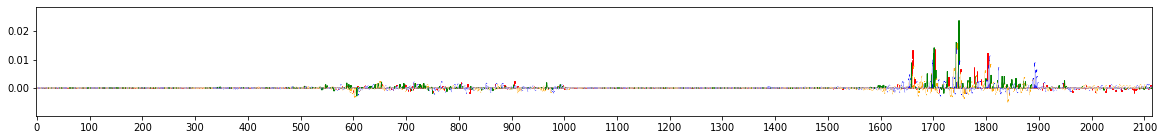

In [97]:
regions = np.logical_and(np.array(normed_counr_shap)>=0.8,np.array(normed_prof_shap)>=0.8)
intersections=np.array(list(input_keys))[regions]
print(len(intersections))

idxc=15
print(intersections[idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots(intersections[idxc], output_reg)

['chr1:43357171:43359285' 'chr1:143263214:143265328'
 'chr2:44549691:44551805' 'chr2:108660658:108662772'
 'chr2:111099490:111101604' 'chr2:156906940:156909054'
 'chr3:37023229:37025343' 'chr3:48715697:48717811'
 'chr3:56916878:56918992' 'chr3:196461817:196463931'
 'chr5:76268737:76270851' 'chr8:27961942:27964056'
 'chr10:55202437:55204551' 'chr17:1626949:1629063'
 'chr17:57945392:57947506' 'chr20:3766144:3768258'
 'chr20:40989666:40991780']


['chr1:86015361:86017475' 'chr1:204745984:204748098'
 'chr1:233606359:233608473' 'chr2:79649128:79651242'
 'chr2:122998820:123000934' 'chr2:128317784:128319898'
 'chr2:148916563:148918677' 'chr2:173941562:173943676'
 'chr3:27451016:27453130' 'chr3:112004311:112006425'
 'chr3:115462744:115464858' 'chr4:85418262:85420376'
 'chr4:95231841:95233955' 'chr4:112118411:112120525'
 'chr4:145054690:145056804' 'chr4:156514414:156516528'
 'chr5:90948841:90950955' 'chr5:157994132:157996246'
 'chr6:54307396:54309510' 'chr6:128258880:128260994'
 'chr7:24575839:24577953' 'chr7:118244575:118246689'
 'chr9:5847638:5849752' 'chr11:60342228:60344342'
 'chr12:75980865:75982979' 'chr13:75415958:75418072'
 'chr13:103883151:103885265' 'chr15:57145621:57147735'
 'chr16:72831697:72833811' 'chr18:77113922:77116036']
